In [1]:
import os, sys

import numpy as np
from scipy.linalg import eigh
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import scipy.linalg as sla
import pandas as pd
import numpy as np
from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from shapely.geometry.polygon import LinearRing

from astropy.io import fits
from astropy import wcs
from matplotlib import cm
from matplotlib.colors import LogNorm

import warnings
warnings.filterwarnings('ignore')

from sbfTools import *

In [2]:
#https://math.stackexchange.com/questions/1114879/detect-if-two-ellipses-intersect

## Object Initialization

In [145]:
# obj = ellOBJ("n0679", outFolder="Outputs_n0679")
# obj = ellOBJ("u12517", outFolder="Outputs_u12517")
# obj = ellOBJ("n0439", outFolder="Outputs_n0439")

# obj = ellOBJ("n6577", outFolder="Outputs_n6577", inFolder='/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262')

# obj = ellOBJ("n3308", outFolder="Outputs_n3308", inFolder='/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262')

# obj = ellOBJ("n7265", outFolder="Outputs_n7265", inFolder='/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262')

# obj = ellOBJ("n3268", outFolder="Outputs_n3268", inFolder='/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262')


### Spiral arms, reject
obj = ellOBJ("n6688", outFolder="Outputs_n6688", inFolder='/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262')

## nuclear dust + companion
# obj = ellOBJ("n4825", outFolder="Outputs_n4825", inFolder='/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262')


In [146]:
obj.sky_med, obj.x0, obj.y0

(1606.150390625, 563.231, 562.4680000000001)

Back Median: 1606.15
Back Mean: 1610.85
Back Stdev: 107.68


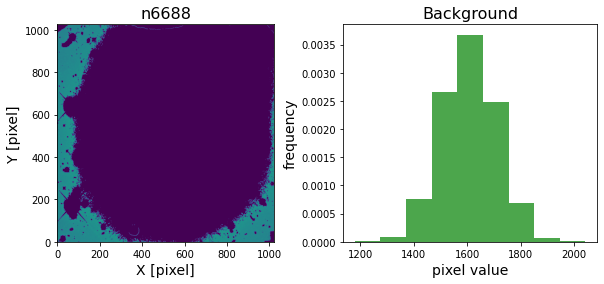

In [147]:
ax1, ax2 = obj.plot_background()

N_cross: 9
r0: 3
r1: 294
nr: 20
sky: 1445
CPU times: user 832 ms, sys: 526 ms, total: 1.36 s
Wall time: 952 ms


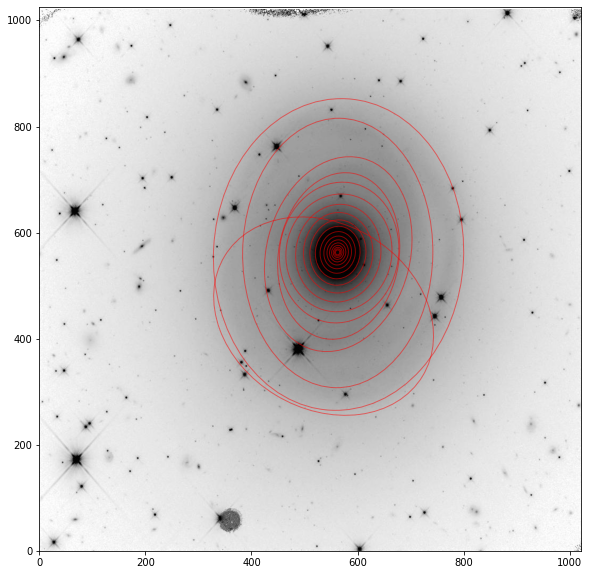

In [148]:
%%time

r0 = 3              # pixel
c_kron = 3       # Kron radius factor
k = 15 
sky_factor = 0.9    # always less than one

r1 = int(c_kron*np.sqrt(obj.a*obj.b))
nr = int(np.round(r1/k))
sky = int(sky_factor*obj.sky_med)

msg = obj.elliprof(r0, r1, nr=nr, sky=sky, niter=10, options="")

n_cross = Xellipses(obj.list_ellipses(model=0))
        
ax = obj.tv(options="sqrt")
ax = obj.plot_ellipse(model=0, ax=ax, alpha=0.5, linewidth=1, edgecolor='r', facecolor='none')

print("N_cross: %d"%n_cross)
print("r0: %d"%r0)
print("r1: %d"%r1)
print("nr: %d"%nr)
print("sky: %d"%sky)

Outputs_n6688//mask.000


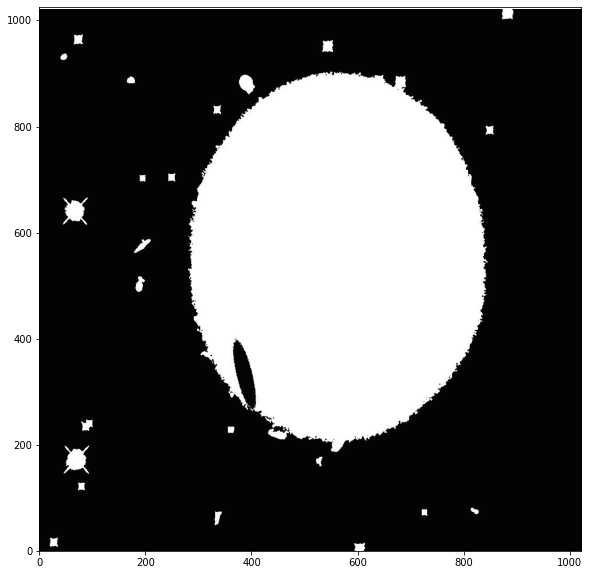

In [149]:
im, mask = obj.naive_Sextract(minArea=20, thresh=5, mask=0)

# plot_2darray(mask)

obj.tv_mask(mask=0)

Outputs_n6688//mask.000


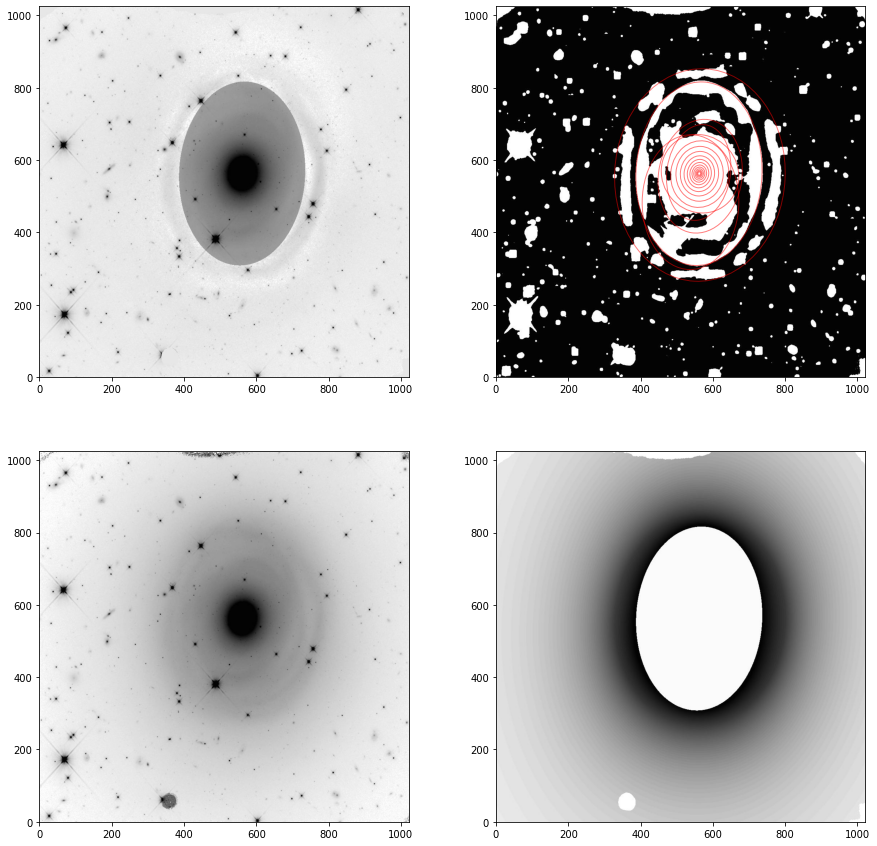

In [150]:
r0 = 3
r1 = int(3.*np.sqrt(obj.a*obj.b))
nr = int(np.round(r1/15))
sky_factor = 0.85    # always less than one


    
# using common mask --> model 0 
obj.elliprof(r0, r1, nr=nr, sky=obj.sky_med, niter=10, options='cos3x=2')

# using residuals of model 0 --> mask 0
obj.objSEextract(model=0, smooth=3, minArea=50, thresh=7) 

# plotting model 0

fig, ax = plt.subplots(2, 2, figsize=(15,15))

obj.tv_resid(model=0, ax = ax[0][0], options='sqrt')
obj.tv_mask(mask=0, ax = ax[0][1])
obj.plot_ellipse(model=0, ax=ax[0][1], alpha=0.5, linewidth=1, edgecolor='r', facecolor='none')


obj.tv(ax = ax[1][0], options='sqrt')
obj.tv_model(model=0, ax=ax[1,1], options='sqrt')

In [151]:
def get_RMS(r0, r1, nr, sky_factor):
    
    sky = int(sky_factor*obj.sky_med)
    n_cross = 0
    
    if obj.elliprof(r0, r1, nr=nr, sky=sky, niter=10, mask=0, model=1) != 'OK':
        n_cross+=1
        
#     obj.objSEextract(model=0, smooth=5, minArea=20, thresh=5) 
#     if obj.elliprof(r0, r1, nr=nr, sky=sky, niter=10, mask=0, model=1) != 'OK':
#         n_cross+=1
    
    n_cross += Xellipses(obj.list_ellipses(model=1))
    model = 1
    root = obj.objRoot
    suffix = '.%03d'%model

    ellipseFile = root+'/elliprof'+suffix
    df = pd.read_csv(ellipseFile, delimiter=r"\s+", skiprows=7)
    df = df.apply(pd.to_numeric, errors='coerce')
    x = df.Rmaj**0.25
    y = 2.5*np.log10(df.I0)

    maxX = np.max(x)
    minX = np.min(x)
    dx = maxX-minX
    x1 = 0.40*dx+minX
    x2 = maxX-0.20*dx
    x3 = maxX-0.10*dx
    x0 = x[((x<x2) & (x>x1))]
    y0 = y[((x<x2) & (x>x1))]

    m, b = np.polyfit(x0, y0, 1)

    x_data = x[((x>=x3))]
    y_data = y[((x>=x3))]
    y_model = m*x_data+b

    rms = np.sqrt(np.mean((y_data.values-y_model.values)**2))
    
    return rms, n_cross

In [152]:
from scipy import optimize
from scipy.optimize import minimize

def f(sky_factor):
    
    r0 = 7
    r1 = int(4.0*np.sqrt(obj.a*obj.b))
    nr = int(np.round(r1/15))
    rms, n_cross = get_RMS(r0, r1, nr, sky_factor)
   
   
    sig = rms 
    
    if sig>10 or np.isnan(sig) or n_cross>0:
        sig = 10
    
    return -sig


In [153]:
from bayes_opt import BayesianOptimization
### https://github.com/fmfn/BayesianOptimization

# Bounded region of parameter space
pbounds = {'sky_factor': (0.65, 1.05)}

optimizer = BayesianOptimization(
    f=f,
    pbounds=pbounds,
    random_state=1,
)

In [154]:
%%time

optimizer.maximize(
    init_points=3,
    n_iter=15,
)

|   iter    |  target   | sky_fa... |
-------------------------------------


TopologyException: found non-noded intersection between LINESTRING (486.571 449.664, 486.571 449.664) and LINESTRING (486.571 449.665, 486.571 449.664) at 486.57082822084664 449.66448034924912


((560.84, 593.1, 139.2, -53.313599999999994, 264.93), (601.03, 747.53, 319.1, 0.0, 248.98))


TopologyException: found non-noded intersection between LINESTRING (486.571 449.664, 486.571 449.664) and LINESTRING (486.571 449.665, 486.571 449.664) at 486.57082822084664 449.66448034924912


((521.6, 804.87, 158.5, 57.5355, 199.76999999999998), (601.03, 747.53, 319.1, 0.0, 248.98))


TopologyException: found non-noded intersection between LINESTRING (486.571 449.664, 486.571 449.664) and LINESTRING (486.571 449.665, 486.571 449.664) at 486.57082822084664 449.66448034924912


((645.58, 816.94, 179.7, 27.673800000000004, 154.05), (601.03, 747.53, 319.1, 0.0, 248.98))


TopologyException: found non-noded intersection between LINESTRING (623.414 805.781, 623.476 805.738) and LINESTRING (623.466 805.916, 623.414 805.781) at 623.41395353467271 805.78140832145982


((637.95, 808.75, 228.3, 10.73010000000001, 145.28), (601.03, 747.53, 319.1, 0.0, 248.98))


Exception ignored on calling ctypes callback function: <function make_logging_callback.<locals>.callback at 0x7f3a9d84bb80>
Traceback (most recent call last):
  File "/home/ehsan/anaconda3/lib/python3.8/site-packages/shapely/geos.py", line 244, in callback
    def callback(fmt, *fmt_args):
KeyboardInterrupt: 


((601.03, 747.53, 319.1, 0.0, 248.98), (694.81, 574.12, 354.6, 11.701799999999972, 269.75))


TopologyException: found non-noded intersection between LINESTRING (548.108 609.807, 548.172 609.973) and LINESTRING (548.235 610.139, 548.172 609.973) at 548.17153796532477 609.97253721949755


((601.03, 747.53, 319.1, 0.0, 248.98), (560.6, 549.12, 393.0, 317.15099999999995, 91.2))
|  1        | -10.0     |  0.8168   |
|  2        | -10.0     |  0.9381   |


KeyboardInterrupt: 

In [155]:
print(optimizer.max)

{'target': -10.0, 'params': {'sky_factor': 0.8168088018810297}}


In [18]:
# %%time 

# result = optimize.minimize_scalar(f, bounds=(0.65, 1.1))

# result

In [19]:
# r0 = 7
# r1 = int(5.0*np.sqrt(obj.a*obj.b))
# nr = int(np.round(r1/15))
# sky_factor = 1.1    # always less than one
# sky = int(sky_factor*obj.sky_med)

# rms_f = 1000
# sky_f = 10

# rms_l0 = []
# sky_l0 = []

# for sky_factor in np.arange(0.6, 1.06, 0.025):
#     sky = int(sky_factor*obj.sky_med)
    
#     obj.elliprof(r0, r1, nr=nr, sky=sky, niter=10)
#     n_cross = Xellipses(obj.list_ellipses(model=0))
#     model = 0
#     root = obj.objRoot
#     suffix = '.%03d'%model

#     ellipseFile = root+'/elliprof'+suffix
#     df = pd.read_csv(ellipseFile, delimiter=r"\s+", skiprows=7)
#     df = df.apply(pd.to_numeric, errors='coerce')
#     x = df.Rmaj**0.25
#     y = 2.5*np.log10(df.I0)

#     maxX = np.max(x)
#     minX = np.min(x)
#     dx = maxX-minX
#     x1 = 0.40*dx+minX
#     x2 = maxX-0.20*dx
#     x0 = x[((x<x2) & (x>x1))]
#     y0 = y[((x<x2) & (x>x1))]
#     ax.plot(x0, y0, 'ko', mfc='white')

#     m, b = np.polyfit(x0, y0, 1)

#     x_data = x[((x>=x2))]
#     y_data = y[((x>=x2))]
#     y_model = m*x_data+b

#     rms = np.sqrt(np.mean((y_data.values-y_model.values)**2))
    
#     print(sky_factor, rms, n_cross)

#     if rms < rms_f and n_cross==0:
#         rms_f = rms
#         sky_f = sky_factor
        
#     if n_cross == 0:
#         sky_l0.append(sky_factor)
#         rms_l0.append(rms)
    
    

In [20]:
# plt.plot(sky_l, rms_l, '.')
# plt.plot(sky_l0, rms_l0, 'r.')

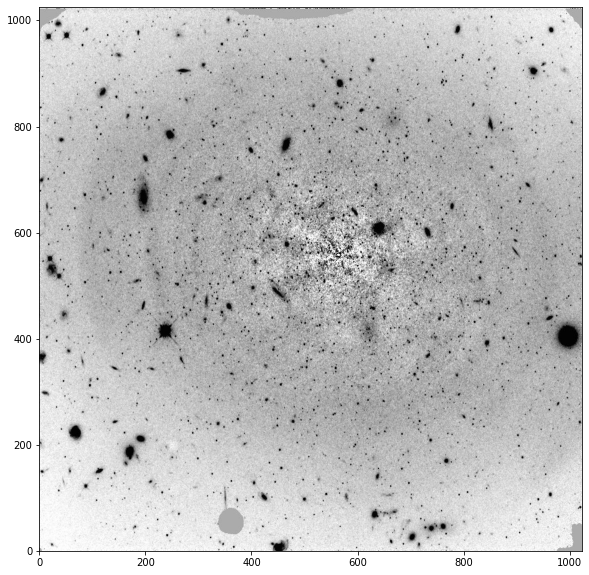

In [106]:
obj.tv_resid(model=0)

Outputs_n3308//mask.000


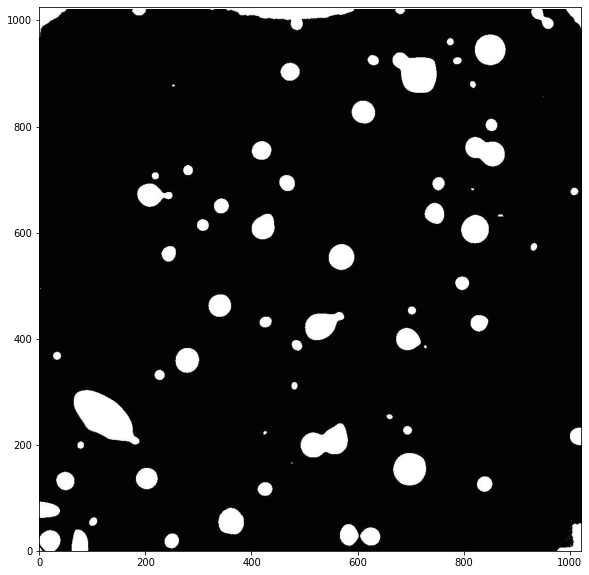

In [88]:
obj.tv_mask(mask=0)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f3a7e5b0c10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3a8d8ceac0>)

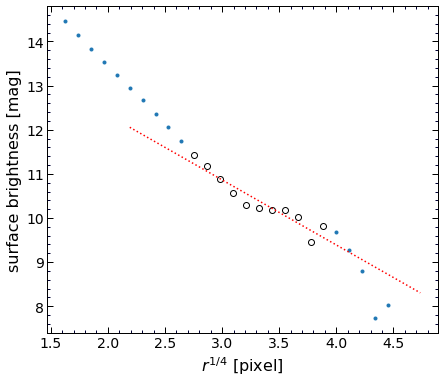

In [158]:
r0 = 7
r1 = int(4*np.sqrt(obj.a*obj.b))
nr = int(np.round(r1/15))
sky_factor = 0.85 # always less than one
sky = int(sky_factor*obj.sky_med)


# using common mask --> model 0 
obj.elliprof(r0, r1, nr=nr, sky=sky, niter=10)

# using mask 0 --> model 1 
obj.elliprof(r0, r1, nr=nr, sky=sky, niter=10, mask=0, model=1)


model = 1
root = obj.objRoot
suffix = '.%03d'%model

ellipseFile = root+'/elliprof'+suffix
df = pd.read_csv(ellipseFile, delimiter=r"\s+", skiprows=7)
df = df.apply(pd.to_numeric, errors='coerce')


fig, ax = plt.subplots(1,1, figsize=(7,6))

x = df.Rmaj**0.25
y = 2.5*np.log10(df.I0)
ax.plot(x, y, '.')

ax.set_xlabel(r"$r^{1/4}$"+" [pixel]", fontsize=16)
ax.set_ylabel(r"surface brightness"+" [mag]", fontsize=16)

maxX = np.max(x)
minX = np.min(x)
dx = maxX-minX
x1 = 0.40*dx+minX
x2 = maxX-0.20*dx
x0 = x[((x<x2) & (x>x1))]
y0 = y[((x<x2) & (x>x1))]
ax.plot(x0, y0, 'ko', mfc='white')

m, b = np.polyfit(x0, y0, 1)

xrange = np.linspace(x1-0.2*dx, maxX+0.1*dx, 100)
yrange = m*xrange+b

ax.plot(xrange, yrange, 'r:')


set_axes(ax, fontsize=14)

11

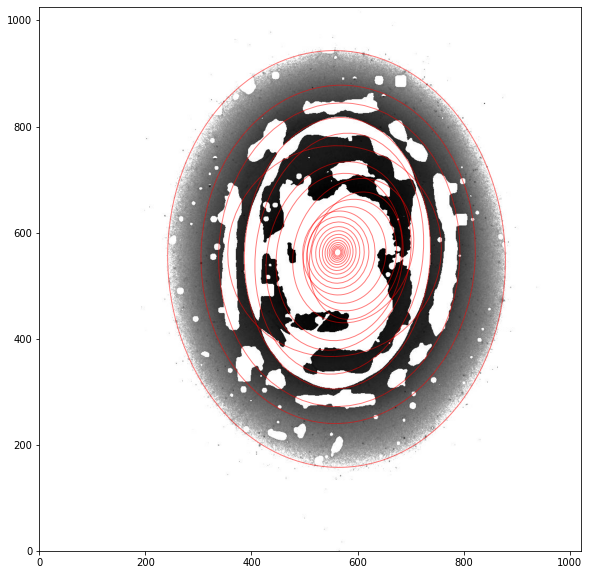

In [159]:
ax = obj.tv_resid(model=1, options='log')
ax = obj.plot_ellipse(model=1, ax=ax, alpha=0.5, linewidth=1, edgecolor='r', facecolor='none')

Xellipses(obj.list_ellipses(model=1))

Back Median: -13118.85
Back Mean: -16486.71
Back Stdev: 10851.24


(array([8.83475725e-07, 2.27254710e-06, 6.30480404e-06, 1.54608252e-05,
        3.46392267e-05, 4.40539706e-05, 5.99078174e-08, 0.00000000e+00,
        0.00000000e+00]),
 array([-59891.6796875 , -50246.13020833, -40600.58072917, -30955.03125   ,
        -21309.48177083, -11663.93229167,  -2018.3828125 ,   7627.16666667,
         17272.71614583,  26918.265625  ]),
 <a list of 9 Patch objects>)

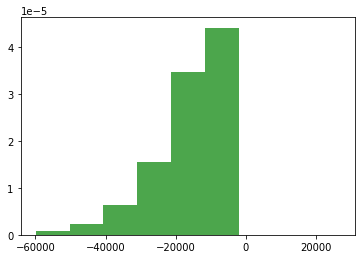

In [160]:

resid_name = obj.objRoot+"resid.001"
back_mask = obj.objRoot+"back_mask.fits"

imarray, header = imOpen(resid_name)
mskarray, header = imOpen(back_mask)

masked_image = imarray*mskarray

fits.writeto('./tmp.fits', np.float32(masked_image), overwrite=True)

## plot_2darray(imarray)
# tv('./tmp.fits', options='log')


a = masked_image
a = a[(a!=0)]
median = np.median(a)
mean = np.mean(a)
std = np.std(a)

print("Back Median: %.2f"%median)
print("Back Mean: %.2f"%mean)
print("Back Stdev: %.2f"%std)

plt.hist(a, bins=np.linspace(mean-4*std, mean+4*std, 10), density=True, color='g', alpha=0.7)

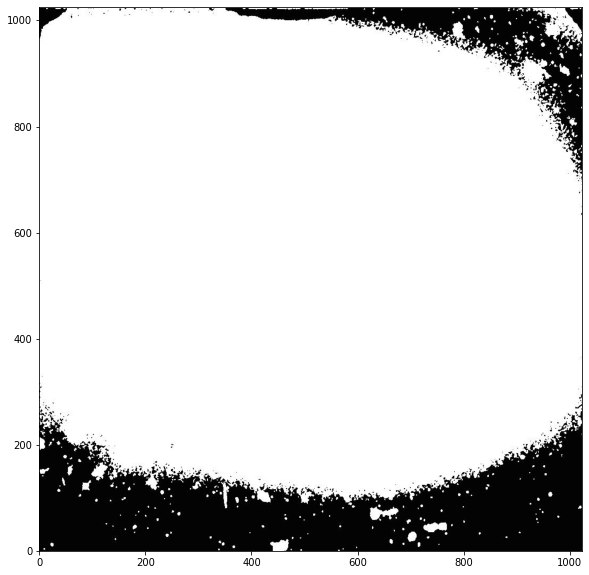

In [51]:
tv(obj.objRoot+"back_mask.fits")

In [ ]:
sky_factor

In [ ]:
%%time

t_indx = 100
indlst = []

for c_kron in np.arange(3, 6, 1):
        for r0 in range(7,11,2):
            for opt in ['', 'COS3X=0','COS3X=1','COS3X=2','COS4X=0','COS4X=1','COS4X=2','COS6X=0','COS6X=-1','COS6X=-2']:
    
                r1 = int(c_kron*np.sqrt(obj.a*obj.b))
                nr = int(np.round(r1/20))
                sky = int(sky_factor*obj.sky_med)


                # generates model 0, using common mask
                if obj.elliprof(r0, r1, nr=nr, sky=sky, niter=10, options=opt) != 'OK':
                    print("Err1: ", t_indx, r0, r1, nr, sky_factor, c_kron)
                    t_indx+=1
                    continue

                n_cross = Xellipses(obj.list_ellipses(model=0))
                if n_cross>0:
                    print("N_cross 1: ", n_cross, t_indx, r0, r1, nr, k, sky_factor, c_kron, opt)
                    t_indx+=1
                    continue

                # usese residuals of model 0, generates mask t
                obj.objSEextract(model=0, smooth=10, minArea=20, thresh=5, mask=t_indx)

                ## generates model t, uses mask t      
                if obj.elliprof(r0, r1, nr=nr, mask=t_indx, model=t_indx, niter=10, sky=sky, options=opt)  != 'OK':
                    print("Err2: ", t_indx, r0, r1, nr, sky_factor, c_kron, opt)
                    t_indx+=1
                    continue

                n_cross = Xellipses(obj.list_ellipses(model=t_indx))
                if n_cross>0:
                    print("N_cross 2: ", n_cross, t_indx, r0, r1, nr, sky_factor, c_kron, opt)
                    t_indx+=1
                    continue

            #     print(t_indx)
                indlst.append(t_indx)
                t_indx+=1


In [ ]:
print(indlst)

In [ ]:
len(indlst)

In [ ]:
def maksOpen(inMask):
    
    ## Monsta script
    script = """
    rd 1 """+inMask+"""
    wd 1 """+inMask+'.fits'+""" 
    q

    """       

    run_monsta(script, 'monsta.pro', 'monsta.log')
    xcmd("rm monsta.log; rm monsta.pro", False)
    return imOpen(inMask+'.fits')

In [ ]:
outFolder = 'Outputs_'+obj.name+'/'

In [ ]:
%%time

IM = None
for idx in indlst:
    suffix = '.%03d'%idx
    mask_name = "mask"+suffix
    
    im, header = maksOpen(outFolder+mask_name)
    im = np.abs(im-1)
    
    if IM is None:
        IM = im
    else:
        IM = IM+im

IM /= len(indlst)
IM[IM>=0.99] = 1
IM[IM<0.99] = 0

IM = np.abs(IM-1)      
plt.imshow(IM, cmap=plt.get_cmap('gray'))


In [ ]:
fits.writeto(outFolder+'mask.super.fits', IM, header, overwrite=True)

In [ ]:
name = obj.name
segment = outFolder+'segment.fits'
objCatal = outFolder+'catal.cat'
objname = "{}/{}j.fits".format(name,name)
sex_cmd = """sex """+objname+""" -c wfc3j.inpar -CHECKIMAGE_TYPE SEGMENTATION -CHECKIMAGE_NAME """+segment
sex_cmd += " -CATALOG_NAME  "+objCatal
sex_cmd += " -DETECT_MINAREA 10"
sex_cmd += " -DETECT_THRESH 2"
sex_cmd += " -WEIGHT_TYPE NONE"
xcmd(sex_cmd, True)
#######################################
im, _ = imOpen(segment)
im[im<=1] = 1
im[im>1] = 0
IM_ = IM * im
plt.imshow(IM, cmap=plt.get_cmap('gray'))
fits.writeto(outFolder+'mask.super.fits', np.float32(IM_), header, overwrite=True)

In [ ]:
obj.tv(options='log')

In [ ]:
tv(outFolder+'mask.super.fits')

In [ ]:
print(indlst)

In [ ]:
model = 109 

obj.plot_resid(model=model)

ax = obj.plot_ellipse(model=model, ax=ax, alpha=0.5, linewidth=1, edgecolor='r', facecolor='none')

Xellipses(obj.list_ellipses(model=model))

In [ ]:
mask_name = "mask.140"
ax = tv('Outputs_'+obj.name+'/'+mask_name)

In [ ]:
r0 = 7
r1 = int(3*np.sqrt(obj.a*obj.b))
nr = int(np.round(r1/14))
sky_factor = 0.9    # always less than one
sky = int(sky_factor*obj.sky_med)


# using common mask --> model 0 
obj.elliprof(r0, r1, nr=nr, sky=obj.sky_med, niter=10, options="COS4X=2")

# using residuals of model 0 --> mask 0
obj.objSEextract(model=0, smooth=3, minArea=10, thresh=5) 

obj.elliprof(r0, r1, nr=nr, sky=obj.sky_med, niter=10, options="COS4X=2", mask=0, model=1)

# plotting model 0
# ax = obj.tv_resid(model=0)

ax = obj.tv_mask(mask=0)

ax = obj.plot_ellipse(model=1, ax=ax, alpha=0.5, linewidth=1, edgecolor='r', facecolor='none')

In [ ]:
%%time

r0 = 3
r1 = int(3*np.sqrt(obj.a*obj.b))
nr = int(np.round(r1/14))
sky_factor = 0.9    # always less than one
sky = int(sky_factor*obj.sky_med)

print(r1, nr, sky)


# generates model 0, using common mask
obj.elliprof(r0, r1, nr=nr, sky=sky, niter=10, options="COS4X=2") 

# usese residuals of model 0, generates mask 0
obj.objSEextract(model=0, smooth=3, minArea=15, thresh=3)    

## generates model 1, uses mask 0      
obj.elliprof(r0, r1, nr=nr, mask=0, model=1, niter=10, sky=sky, options="COS4X=2")  

ax = obj.tv_resid(model=1)

# ax = obj.tv(options='sqrt cf=jt')
# Ell = make_Ellipse([obj.x0, obj.y0], obj.a, obj.b, obj.angle)
# plot_Ellipse(Ell, ax=ax, edgecolor='r', facecolor='none')

# ax = obj.plot_ellipse(model=1, ax=ax, alpha=0.5, linewidth=1, edgecolor='r', facecolor='none')



ax.set_title(obj.name, fontsize=16)

In [ ]:
mask_name = "mask.000"
ax = tv('Outputs_'+obj.name+'/'+mask_name)

In [ ]:
obj.tv(options="sqt", additions="smooth 1 fw=0")

In [ ]:
ax = tv('Outputs_n0679/mask.000')
# ax = obj.plot_ellipse(model=0, ax=ax, alpha=0.5, linewidth=2, edgecolor='r', facecolor='none')

In [ ]:
ax = obj.plot_object(model=0)
ax = obj.plot_ellipse(model=0, ax=ax, alpha=0.5, linewidth=2, edgecolor='g', facecolor='none')

In [ ]:
ax = obj.plot_resid(model=0)
ax = obj.plot_ellipse(model=0, ax=ax, alpha=0.5, linewidth=2, edgecolor='g', facecolor='none')

In [ ]:
obj.tv(options="sqrt cf=jt")

In [ ]:
obj.tv_resid(model=0, options="sqrt")

In [ ]:
obj.tv_model(model=0, options="sqrt")

In [ ]:
imarray.shape